In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['train_targets_scored.csv',
 'train_drug.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'sample_submission.csv',
 'test_features.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
train_drug = pd.read_csv('../input/lish-moa/train_drug.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
predictors = GENES+CELLS

In [5]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [6]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [9]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [11]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [12]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [13]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [14]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [15]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [16]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [17]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical, columns=columns_)
    test_features_ = pd.DataFrame(test_features_numerical, columns=columns_)
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features, test_features

# train_features, test_features = scaling(train_features, test_features)
# train_features

In [18]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [19]:
def preprocessor(train_features, test_features, train_targets_scored, train_targets_nonscored):
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
#     print('drop_ctl_vehicle: done')
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('get_clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')  # ない方がいいかも。
    
    # data merge
    nonscored_cols = train_targets_nonscored.iloc[:, 1:].sum(axis=0).sort_values(ascending=False).index.tolist() # Moaが多い順にカラムを取得
    nonscored_cols = ['sig_id'] + nonscored_cols[:train_targets_scored.shape[1]-1]
    train_targets_nonscored = train_targets_nonscored[nonscored_cols] # MoAが多い順にnonscoredからscoredと同じ分だけ抜き取る
    
    train = train_features.merge(train_targets_scored, on='sig_id').merge(train_targets_nonscored, on='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    target_nonscored = train[train_targets_nonscored.columns]
    target_nonscored = target_nonscored.iloc[:, :target.shape[1]]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test, target_nonscored

train, target, test, target_nonscored = preprocessor(train_features, test_features, train_targets_scored, train_targets_nonscored)

rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [20]:
folds = make_folds(train, num_starts=5, num_splits=5)

In [21]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_nonscored_cols = target_nonscored.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if (c not in target_cols) & (c not in target_nonscored_cols)]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
len(feature_cols)

1045

### shape check

In [22]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'target_nonscored.shape: {target_nonscored.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1455)
folds.shape: (21948, 1460)
test.shape: (3624, 1043)
target.shape: (21948, 207)
target_nonscored.shape: (21948, 207)
sample_submission.shape: (3982, 207)


In [23]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'target_nonscored': target_nonscored, 
    'sample_submission': sample_submission
}

In [24]:
with open('all_data_ResNet.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [25]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### training function

In [26]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1: 
            inputs1 = inputs[:, :-len(predictors)]
            inputs2 = inputs[:, -len(predictors):]
            outputs = model(inputs1, inputs2)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
            final_loss += loss.item()
            final_metric += metric.item()
            
        else:
            rejected += len(inputs)
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [27]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        inputs1 = inputs[:, :-len(predictors)]
        inputs2 = inputs[:, -len(predictors):]
        outputs = model(inputs1, inputs2)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [28]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        inputs1 = inputs[:, :-len(predictors)]
        inputs2 = inputs[:, -len(predictors):]
        
        with torch.no_grad():
            outputs = model(inputs1, inputs2)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [29]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [30]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### HyperParameters

In [31]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 35
BATCH_SIZE = 128
BATCH_SIZE_nonscored = 512
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False
EARLY_STOPPING_STEPS_nonscored = 4
EARLY_STOP_nonscored = True
smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

num_features_1 = len(feature_cols)
num_features_2 = len(predictors)
num_targets = len(target_cols)
hidden_1 = 256
hidden_2 = 256

### Model

In [32]:
class Model_ResNet(nn.Module):
    def __init__(self, num_features_1, num_features_2, num_targets, hidden_1, hidden_2):
        super(Model_ResNet, self).__init__()
        
        self.batchnorm1_1 = nn.BatchNorm1d(num_features_1)
        self.dropout1_1 = nn.Dropout(0.3)
        self.Linear1_1 = nn.Linear(num_features_1, hidden_1)
        self.relu1_1 = nn.ReLU()
        self.batchnorm1_2 = nn.BatchNorm1d(hidden_1)
        self.Linear1_2 = nn.Linear(hidden_1, hidden_2)
        self.relu1_2 = nn.ReLU()
        
        self.batchnorm2_1 = nn.BatchNorm1d(num_features_2+hidden_2)
        self.dropout2_1 = nn.Dropout(0.3)
        self.Linear2_1 = nn.Linear(num_features_2+hidden_2, hidden_1)
        self.relu2_1 = nn.ReLU()
        self.batchnorm2_2 = nn.BatchNorm1d(hidden_1)
        self.Linear2_2 = nn.Linear(hidden_1, hidden_1)
        self.relu2_2 = nn.ReLU()
        self.batchnorm2_3 = nn.BatchNorm1d(hidden_1)
        self.Linear2_3 = nn.Linear(hidden_1, hidden_2)
        self.relu2_3 = nn.ReLU()
        
        self.batchnorm3_1 = nn.BatchNorm1d(hidden_2)
        self.Linear3_1 = nn.Linear(hidden_2, hidden_2)
        self.relu3_1 = nn.ReLU()
        self.batchnorm3_2 = nn.BatchNorm1d(hidden_2) 
        self.Linear3_2 = nn.Linear(hidden_2, num_targets)
        
        
        
    def recalibrate_layer(self, layer):

        if(torch.isnan(layer.weight_v).sum() > 0):
            print ('recalibrate layer.weight_v')
            layer.weight_v = torch.nn.Parameter(torch.where(torch.isnan(layer.weight_v), torch.zeros_like(layer.weight_v), layer.weight_v))
            layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)

        if(torch.isnan(layer.weight).sum() > 0):
            print ('recalibrate layer.weight')
            layer.weight = torch.where(torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight)
            layer.weight += 1e-7
            
    def forward(self, x_1, x_2):
        
        input_1 = x_1
        input_2 = x_2
        
        input_3 = self.batchnorm1_1(input_1)
        input_3 = self.dropout1_1(input_3)
        input_3 = self.Linear1_1(input_3)
        input_3 = self.relu1_1(input_3)
        input_3 = self.batchnorm1_2(input_3)
        input_3 = self.Linear1_2(input_3)
        input_3 = self.relu1_2(input_3)
        
        input_3_concat = torch.cat([input_2, input_3], axis=1)
        
        input_4 = self.batchnorm2_1(input_3_concat)
        input_4 = self.dropout2_1(input_4)
        input_4 = self.Linear2_1(input_4)
        input_4 = self.relu2_1(input_4)
        input_4 = self.batchnorm2_2(input_4)
        input_4 = self.Linear2_2(input_4)
        input_4 = self.relu2_2(input_4)
        input_4 = self.batchnorm2_3(input_4)
        input_4 = self.Linear2_3(input_4)
        input_4 = self.relu2_3(input_4)
        
        input_4_avg = (input_3 + input_4) * 0.5
        
        output = self.batchnorm3_1(input_4_avg)
        output = self.Linear3_1(output)
        output = self.relu3_1(output)
        output = self.batchnorm3_2(output)
        output = self.Linear3_2(output)
        
        return output

### Single fold training

In [33]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    train_losses_nonscored = list()
    valid_losses_nonscored = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train[f'seed{seed}'] != fold].index
    val_idx = train[train[f'seed{seed}'] == fold].index
    
    train_df = train[train[f'seed{seed}'] != fold].reset_index()
    valid_df = train[train[f'seed{seed}'] == fold].reset_index()
    
    x_train, y_train, y_train_nonscored = train_df[feature_cols].values, train_df[target_cols].values, train_df[target_nonscored_cols].values
    x_valid, y_valid, y_valid_nonscored = valid_df[feature_cols].values, valid_df[target_cols].values, valid_df[target_nonscored_cols].values
    
    x_train2 = train_df[predictors].values
    x_valid2 = valid_df[predictors].values
    
    x_train = np.concatenate([x_train, x_train2], axis=1)
    x_valid = np.concatenate([x_valid, x_valid2], axis=1)
    
    train_dataset = MoADataset(x_train, y_train)
    train_dataset_nonscored = MoADataset(x_train, y_train_nonscored)
    valid_dataset = MoADataset(x_valid, y_valid)
    valid_dataset_nonscored = MoADataset(x_valid, y_valid_nonscored)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    trainloader_nonscored = torch.utils.data.DataLoader(train_dataset_nonscored, batch_size=BATCH_SIZE_nonscored, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    validloader_nonscored = torch.utils.data.DataLoader(valid_dataset_nonscored, batch_size=BATCH_SIZE_nonscored, shuffle=False)
    
    model = Model_ResNet(num_features_1=num_features_1,
                      num_features_2=num_features_2, 
                      num_targets=num_targets, 
                      hidden_1=hidden_1,
                      hidden_2=hidden_2)
    

    model.to(DEVICE)
    
    optimizer_nonscored = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler_nonscored = optim.lr_scheduler.OneCycleLR(optimizer=optimizer_nonscored, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader_nonscored)) 
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing=smoothing)
    
    early_stoppping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    early_step_nonscored = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    print('nonscored-loop')
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer_nonscored, scheduler_nonscored, loss_tr, loss_fn, trainloader_nonscored, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses_nonscored.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader_nonscored, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses_nonscored.append(valid_metric)
        
        if valid_loss < best_loss:
            
            early_step_nonscored = 0
            best_loss = valid_loss
#             oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'ResNet_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP_nonscored == True):
            
            early_step_nonscored += 1
            if (early_step_nonscored >= EARLY_STOPPING_STEPS_nonscored):
                print('early_stopping')
                break
    
    plt.plot(train_losses_nonscored, label='train_losses')
    plt.plot(valid_losses_nonscored, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-3, 1e-2])
    plt.title(f'fold{fold+1} losses')
    plt.legend(loc='best')
    plt.show()
    
    
    model.load_state_dict(torch.load(f'ResNet_FOLD{fold+1}_SEED{seed}.pth'))
    model.Linear3_2 = nn.Linear(hidden_2, num_targets)
    model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader)) 
    
    best_loss = np.inf
    
    print('scored_loop')
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses.append(valid_metric)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'ResNet_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= EARLY_STOPPING_STEPS):
                break
                
    y_true = train_targets_scored[target_cols].values

    cv = 0
    for i in range(len(target_cols)):
        cv_ = log_loss(y_true[val_idx, i], oof[val_idx, i], labels=[0, 1])
        cv += cv_ / len(target_cols)
                
    plt.plot(train_losses, label='train_losses')
    plt.plot(valid_losses, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-2, 2e-2])
    plt.title(f'fold{fold+1} losses')
    plt.legend(loc='best')
    plt.show()
                
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    x_test2 = test_[predictors].values
    
    x_test = np.concatenate([x_test, x_test2], axis=1)
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_ResNet(num_features_1=num_features_1,
                      num_features_2=num_features_2, 
                      num_targets=num_targets, 
                      hidden_1=hidden_1,
                      hidden_2=hidden_2)
    
    model.load_state_dict(torch.load(f'ResNet_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions, cv

In [34]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    CVs = list()
    
    for fold in range(NFOLDS):
        oof_, pred_, cv_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        CVs.append(cv_)
        
    return oof, predictions, CVs

used device: cuda
 
SEED : 0

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72778, train_metric: 0.72778
valid_loss: 0.70572, valid_metric: 0.70572
-----EPOCH2-----
train_loss: 0.69372, train_metric: 0.69371
valid_loss: 0.67013, valid_metric: 0.67009
-----EPOCH3-----
train_loss: 0.52201, train_metric: 0.52180
valid_loss: 0.22779, valid_metric: 0.22710
-----EPOCH4-----
train_loss: 0.06198, train_metric: 0.06019
valid_loss: 0.01241, valid_metric: 0.00963
-----EPOCH5-----
train_loss: 0.01088, train_metric: 0.00774
valid_loss: 0.01136, valid_metric: 0.00814
-----EPOCH6-----
train_loss: 0.01062, train_metric: 0.00736
valid_loss: 0.01134, valid_metric: 0.00811
-----EPOCH7-----
train_loss: 0.01058, train_metric: 0.00737
valid_loss: 0.01143, valid_metric: 0.00828
-----EPOCH8-----
train_loss: 0.01060, train_metric: 0.00743
valid_loss: 0.01145, valid_metric: 0.00829
-----EPOCH9-----
train_loss: 0.01053, train_metric: 0.00736
valid_loss: 0.01138, valid_metric: 0.00820
--

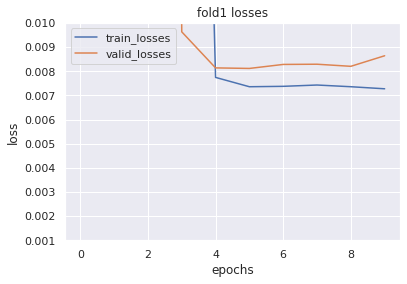

scored_loop
-----EPOCH1-----
train_loss: 0.66082, train_metric: 0.66076
valid_loss: 0.45608, valid_metric: 0.45579
-----EPOCH2-----
train_loss: 0.18433, train_metric: 0.18334
valid_loss: 0.04188, valid_metric: 0.04011
-----EPOCH3-----
train_loss: 0.02895, train_metric: 0.02673
valid_loss: 0.02286, valid_metric: 0.02031
-----EPOCH4-----
train_loss: 0.02208, train_metric: 0.01934
valid_loss: 0.02109, valid_metric: 0.01818
-----EPOCH5-----
train_loss: 0.02119, train_metric: 0.01823
valid_loss: 0.02084, valid_metric: 0.01781
-----EPOCH6-----
train_loss: 0.02099, train_metric: 0.01794
valid_loss: 0.02073, valid_metric: 0.01762
-----EPOCH7-----
train_loss: 0.02097, train_metric: 0.01791
valid_loss: 0.02088, valid_metric: 0.01779
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01782
valid_loss: 0.02092, valid_metric: 0.01776
-----EPOCH9-----
train_loss: 0.02092, train_metric: 0.01787
valid_loss: 0.02093, valid_metric: 0.01794
-----EPOCH10-----
train_loss: 0.02083, train_metric: 0.01778


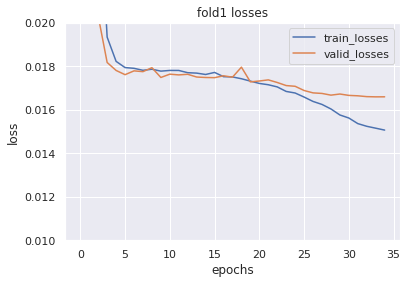

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72769, train_metric: 0.72769
valid_loss: 0.70426, valid_metric: 0.70426
-----EPOCH2-----
train_loss: 0.69362, train_metric: 0.69362
valid_loss: 0.66867, valid_metric: 0.66864
-----EPOCH3-----
train_loss: 0.52356, train_metric: 0.52335
valid_loss: 0.23887, valid_metric: 0.23821
-----EPOCH4-----
train_loss: 0.06299, train_metric: 0.06121
valid_loss: 0.01216, valid_metric: 0.00937
-----EPOCH5-----
train_loss: 0.01089, train_metric: 0.00776
valid_loss: 0.01112, valid_metric: 0.00787
-----EPOCH6-----
train_loss: 0.01064, train_metric: 0.00738
valid_loss: 0.01114, valid_metric: 0.00792
-----EPOCH7-----
train_loss: 0.01063, train_metric: 0.00742
valid_loss: 0.01119, valid_metric: 0.00801
-----EPOCH8-----
train_loss: 0.01056, train_metric: 0.00738
valid_loss: 0.01116, valid_metric: 0.00796
-----EPOCH9-----
train_loss: 0.01051, train_metric: 0.00734
valid_loss: 0.01121, valid_metric: 0.00804
early_stopping


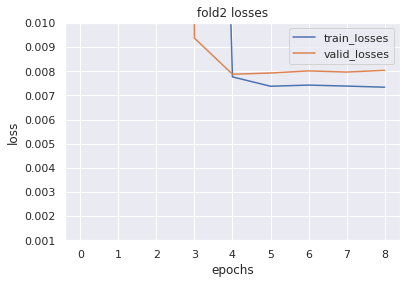

scored_loop
-----EPOCH1-----
train_loss: 0.64193, train_metric: 0.64185
valid_loss: 0.44158, valid_metric: 0.44127
-----EPOCH2-----
train_loss: 0.17972, train_metric: 0.17872
valid_loss: 0.04189, valid_metric: 0.04011
-----EPOCH3-----
train_loss: 0.02853, train_metric: 0.02631
valid_loss: 0.02331, valid_metric: 0.02075
-----EPOCH4-----
train_loss: 0.02181, train_metric: 0.01906
valid_loss: 0.02185, valid_metric: 0.01898
-----EPOCH5-----
train_loss: 0.02094, train_metric: 0.01797
valid_loss: 0.02156, valid_metric: 0.01847
-----EPOCH6-----
train_loss: 0.02075, train_metric: 0.01769
valid_loss: 0.02149, valid_metric: 0.01841
-----EPOCH7-----
train_loss: 0.02069, train_metric: 0.01762
valid_loss: 0.02145, valid_metric: 0.01841
-----EPOCH8-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02152, valid_metric: 0.01838
-----EPOCH9-----
train_loss: 0.02065, train_metric: 0.01760
valid_loss: 0.02146, valid_metric: 0.01846
-----EPOCH10-----
train_loss: 0.02071, train_metric: 0.01766


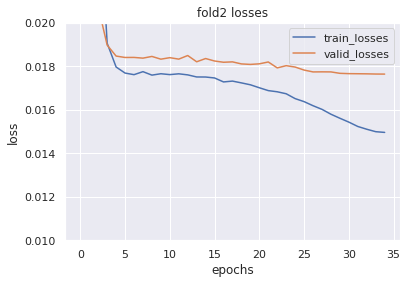

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72775, train_metric: 0.72775
valid_loss: 0.70374, valid_metric: 0.70373
-----EPOCH2-----
train_loss: 0.69368, train_metric: 0.69368
valid_loss: 0.67284, valid_metric: 0.67281
-----EPOCH3-----
train_loss: 0.52364, train_metric: 0.52343
valid_loss: 0.23854, valid_metric: 0.23788
-----EPOCH4-----
train_loss: 0.06320, train_metric: 0.06142
valid_loss: 0.01148, valid_metric: 0.00871
-----EPOCH5-----
train_loss: 0.01116, train_metric: 0.00803
valid_loss: 0.01027, valid_metric: 0.00702
-----EPOCH6-----
train_loss: 0.01091, train_metric: 0.00766
valid_loss: 0.01037, valid_metric: 0.00721
-----EPOCH7-----
train_loss: 0.01087, train_metric: 0.00767
valid_loss: 0.01041, valid_metric: 0.00730
-----EPOCH8-----
train_loss: 0.01077, train_metric: 0.00761
valid_loss: 0.01041, valid_metric: 0.00729
-----EPOCH9-----
train_loss: 0.01074, train_metric: 0.00758
valid_loss: 0.01034, valid_metric: 0.00715
early_stopping


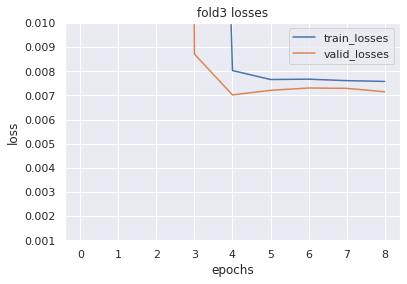

scored_loop
-----EPOCH1-----
train_loss: 0.64657, train_metric: 0.64649
valid_loss: 0.44975, valid_metric: 0.44945
-----EPOCH2-----
train_loss: 0.18052, train_metric: 0.17952
valid_loss: 0.04271, valid_metric: 0.04096
-----EPOCH3-----
train_loss: 0.02863, train_metric: 0.02642
valid_loss: 0.02288, valid_metric: 0.02028
-----EPOCH4-----
train_loss: 0.02195, train_metric: 0.01921
valid_loss: 0.02133, valid_metric: 0.01841
-----EPOCH5-----
train_loss: 0.02112, train_metric: 0.01817
valid_loss: 0.02134, valid_metric: 0.01842
-----EPOCH6-----
train_loss: 0.02093, train_metric: 0.01789
valid_loss: 0.02102, valid_metric: 0.01793
-----EPOCH7-----
train_loss: 0.02100, train_metric: 0.01793
valid_loss: 0.02118, valid_metric: 0.01812
-----EPOCH8-----
train_loss: 0.02091, train_metric: 0.01785
valid_loss: 0.02103, valid_metric: 0.01788
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01777
valid_loss: 0.02130, valid_metric: 0.01835
-----EPOCH10-----
train_loss: 0.02091, train_metric: 0.01786


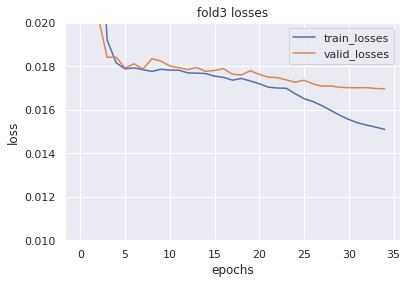

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72764, train_metric: 0.72764
valid_loss: 0.70421, valid_metric: 0.70421
-----EPOCH2-----
train_loss: 0.69359, train_metric: 0.69358
valid_loss: 0.67083, valid_metric: 0.67080
-----EPOCH3-----
train_loss: 0.52225, train_metric: 0.52204
valid_loss: 0.23410, valid_metric: 0.23343
-----EPOCH4-----
train_loss: 0.06234, train_metric: 0.06055
valid_loss: 0.01196, valid_metric: 0.00919
-----EPOCH5-----
train_loss: 0.01100, train_metric: 0.00787
valid_loss: 0.01073, valid_metric: 0.00751
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00750
valid_loss: 0.01070, valid_metric: 0.00743
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00755
valid_loss: 0.01076, valid_metric: 0.00760
-----EPOCH8-----
train_loss: 0.01068, train_metric: 0.00751
valid_loss: 0.01094, valid_metric: 0.00791
-----EPOCH9-----
train_loss: 0.01065, train_metric: 0.00749
valid_loss: 0.01079, valid_metric: 0.00764
-----EPOCH10-----
train_loss: 0.

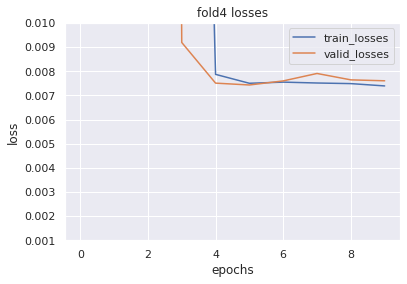

scored_loop
-----EPOCH1-----
train_loss: 0.64986, train_metric: 0.64979
valid_loss: 0.44697, valid_metric: 0.44666
-----EPOCH2-----
train_loss: 0.18214, train_metric: 0.18115
valid_loss: 0.04235, valid_metric: 0.04059
-----EPOCH3-----
train_loss: 0.02876, train_metric: 0.02655
valid_loss: 0.02329, valid_metric: 0.02076
-----EPOCH4-----
train_loss: 0.02180, train_metric: 0.01906
valid_loss: 0.02169, valid_metric: 0.01885
-----EPOCH5-----
train_loss: 0.02095, train_metric: 0.01798
valid_loss: 0.02139, valid_metric: 0.01824
-----EPOCH6-----
train_loss: 0.02080, train_metric: 0.01775
valid_loss: 0.02118, valid_metric: 0.01811
-----EPOCH7-----
train_loss: 0.02086, train_metric: 0.01780
valid_loss: 0.02144, valid_metric: 0.01833
-----EPOCH8-----
train_loss: 0.02079, train_metric: 0.01773
valid_loss: 0.02112, valid_metric: 0.01804
-----EPOCH9-----
train_loss: 0.02094, train_metric: 0.01788
valid_loss: 0.02174, valid_metric: 0.01880
-----EPOCH10-----
train_loss: 0.02083, train_metric: 0.01778


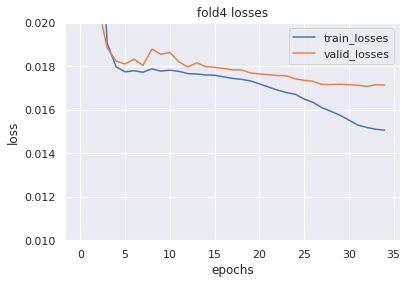

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72764, train_metric: 0.72764
valid_loss: 0.70429, valid_metric: 0.70429
-----EPOCH2-----
train_loss: 0.69357, train_metric: 0.69356
valid_loss: 0.66733, valid_metric: 0.66730
-----EPOCH3-----
train_loss: 0.52282, train_metric: 0.52262
valid_loss: 0.23508, valid_metric: 0.23441
-----EPOCH4-----
train_loss: 0.06260, train_metric: 0.06082
valid_loss: 0.01231, valid_metric: 0.00954
-----EPOCH5-----
train_loss: 0.01097, train_metric: 0.00784
valid_loss: 0.01122, valid_metric: 0.00803
-----EPOCH6-----
train_loss: 0.01067, train_metric: 0.00741
valid_loss: 0.01120, valid_metric: 0.00796
-----EPOCH7-----
train_loss: 0.01062, train_metric: 0.00742
valid_loss: 0.01124, valid_metric: 0.00798
-----EPOCH8-----
train_loss: 0.01061, train_metric: 0.00743
valid_loss: 0.01140, valid_metric: 0.00827
-----EPOCH9-----
train_loss: 0.01055, train_metric: 0.00737
valid_loss: 0.01129, valid_metric: 0.00809
-----EPOCH10-----
train_loss: 0.

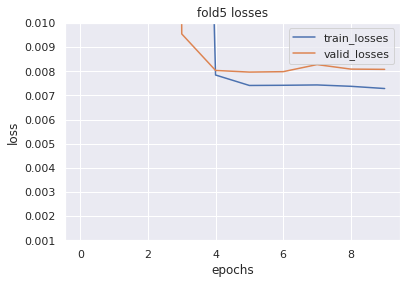

scored_loop
-----EPOCH1-----
train_loss: 0.64625, train_metric: 0.64617
valid_loss: 0.44384, valid_metric: 0.44353
-----EPOCH2-----
train_loss: 0.18009, train_metric: 0.17909
valid_loss: 0.04260, valid_metric: 0.04084
-----EPOCH3-----
train_loss: 0.02864, train_metric: 0.02641
valid_loss: 0.02338, valid_metric: 0.02086
-----EPOCH4-----
train_loss: 0.02199, train_metric: 0.01925
valid_loss: 0.02188, valid_metric: 0.01906
-----EPOCH5-----
train_loss: 0.02114, train_metric: 0.01817
valid_loss: 0.02135, valid_metric: 0.01840
-----EPOCH6-----
train_loss: 0.02092, train_metric: 0.01788
valid_loss: 0.02180, valid_metric: 0.01872
-----EPOCH7-----
train_loss: 0.02111, train_metric: 0.01804
valid_loss: 0.02139, valid_metric: 0.01824
-----EPOCH8-----
train_loss: 0.02102, train_metric: 0.01796
valid_loss: 0.02167, valid_metric: 0.01845
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02122, valid_metric: 0.01808
-----EPOCH10-----
train_loss: 0.02084, train_metric: 0.01778


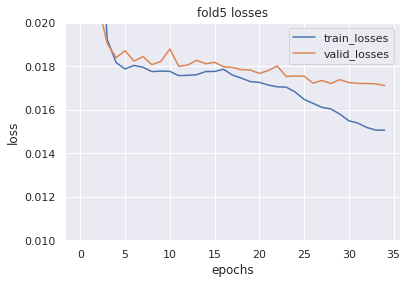

 
SEED : 1

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72482, train_metric: 0.72481
valid_loss: 0.70782, valid_metric: 0.70782
-----EPOCH2-----
train_loss: 0.69116, train_metric: 0.69115
valid_loss: 0.65949, valid_metric: 0.65945
-----EPOCH3-----
train_loss: 0.52199, train_metric: 0.52178
valid_loss: 0.22404, valid_metric: 0.22334
-----EPOCH4-----
train_loss: 0.06316, train_metric: 0.06138
valid_loss: 0.01252, valid_metric: 0.00972
-----EPOCH5-----
train_loss: 0.01090, train_metric: 0.00776
valid_loss: 0.01153, valid_metric: 0.00831
-----EPOCH6-----
train_loss: 0.01058, train_metric: 0.00732
valid_loss: 0.01150, valid_metric: 0.00832
-----EPOCH7-----
train_loss: 0.01055, train_metric: 0.00735
valid_loss: 0.01160, valid_metric: 0.00854
-----EPOCH8-----
train_loss: 0.01050, train_metric: 0.00733
valid_loss: 0.01156, valid_metric: 0.00844
-----EPOCH9-----
train_loss: 0.01043, train_metric: 0.00726
valid_loss: 0.01161, valid_metric: 0.00853
-----EPOCH10-----
tr

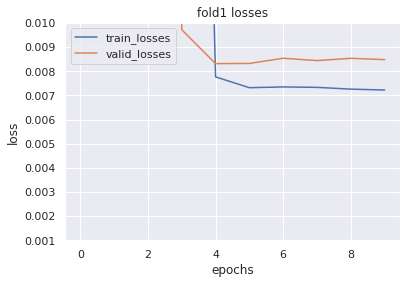

scored_loop
-----EPOCH1-----
train_loss: 0.64639, train_metric: 0.64631
valid_loss: 0.44595, valid_metric: 0.44564
-----EPOCH2-----
train_loss: 0.17962, train_metric: 0.17861
valid_loss: 0.04213, valid_metric: 0.04036
-----EPOCH3-----
train_loss: 0.02849, train_metric: 0.02627
valid_loss: 0.02287, valid_metric: 0.02028
-----EPOCH4-----
train_loss: 0.02178, train_metric: 0.01903
valid_loss: 0.02160, valid_metric: 0.01876
-----EPOCH5-----
train_loss: 0.02096, train_metric: 0.01799
valid_loss: 0.02111, valid_metric: 0.01807
-----EPOCH6-----
train_loss: 0.02077, train_metric: 0.01772
valid_loss: 0.02117, valid_metric: 0.01810
-----EPOCH7-----
train_loss: 0.02073, train_metric: 0.01766
valid_loss: 0.02125, valid_metric: 0.01804
-----EPOCH8-----
train_loss: 0.02076, train_metric: 0.01770
valid_loss: 0.02110, valid_metric: 0.01801
-----EPOCH9-----
train_loss: 0.02071, train_metric: 0.01764
valid_loss: 0.02111, valid_metric: 0.01806
-----EPOCH10-----
train_loss: 0.02070, train_metric: 0.01765


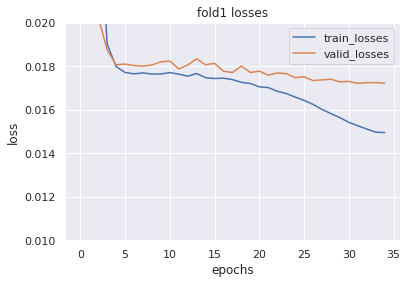

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72471, train_metric: 0.72471
valid_loss: 0.70761, valid_metric: 0.70761
-----EPOCH2-----
train_loss: 0.69101, train_metric: 0.69100
valid_loss: 0.65867, valid_metric: 0.65863
-----EPOCH3-----
train_loss: 0.52214, train_metric: 0.52193
valid_loss: 0.22624, valid_metric: 0.22555
-----EPOCH4-----
train_loss: 0.06345, train_metric: 0.06167
valid_loss: 0.01168, valid_metric: 0.00889
-----EPOCH5-----
train_loss: 0.01120, train_metric: 0.00807
valid_loss: 0.01047, valid_metric: 0.00727
-----EPOCH6-----
train_loss: 0.01092, train_metric: 0.00766
valid_loss: 0.01050, valid_metric: 0.00736
-----EPOCH7-----
train_loss: 0.01083, train_metric: 0.00764
valid_loss: 0.01047, valid_metric: 0.00732
-----EPOCH8-----
train_loss: 0.01078, train_metric: 0.00762
valid_loss: 0.01060, valid_metric: 0.00745
-----EPOCH9-----
train_loss: 0.01078, train_metric: 0.00762
valid_loss: 0.01055, valid_metric: 0.00743
-----EPOCH10-----
train_loss: 0.

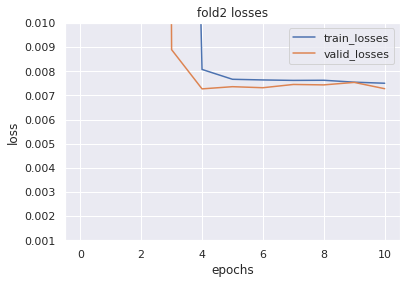

scored_loop
-----EPOCH1-----
train_loss: 0.63664, train_metric: 0.63655
valid_loss: 0.43008, valid_metric: 0.42975
-----EPOCH2-----
train_loss: 0.17258, train_metric: 0.17156
valid_loss: 0.04246, valid_metric: 0.04071
-----EPOCH3-----
train_loss: 0.02861, train_metric: 0.02640
valid_loss: 0.02298, valid_metric: 0.02043
-----EPOCH4-----
train_loss: 0.02186, train_metric: 0.01913
valid_loss: 0.02144, valid_metric: 0.01853
-----EPOCH5-----
train_loss: 0.02099, train_metric: 0.01803
valid_loss: 0.02118, valid_metric: 0.01816
-----EPOCH6-----
train_loss: 0.02079, train_metric: 0.01775
valid_loss: 0.02150, valid_metric: 0.01855
-----EPOCH7-----
train_loss: 0.02071, train_metric: 0.01765
valid_loss: 0.02175, valid_metric: 0.01873
-----EPOCH8-----
train_loss: 0.02074, train_metric: 0.01767
valid_loss: 0.02085, valid_metric: 0.01774
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01770
valid_loss: 0.02083, valid_metric: 0.01776
-----EPOCH10-----
train_loss: 0.02063, train_metric: 0.01757


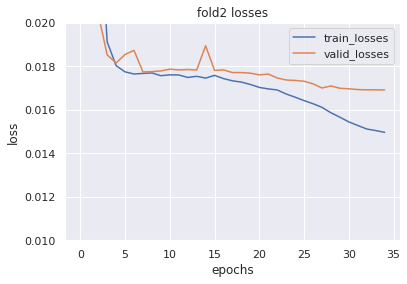

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72476, train_metric: 0.72476
valid_loss: 0.70744, valid_metric: 0.70744
-----EPOCH2-----
train_loss: 0.69103, train_metric: 0.69102
valid_loss: 0.65732, valid_metric: 0.65727
-----EPOCH3-----
train_loss: 0.52196, train_metric: 0.52175
valid_loss: 0.22475, valid_metric: 0.22405
-----EPOCH4-----
train_loss: 0.06320, train_metric: 0.06142
valid_loss: 0.01201, valid_metric: 0.00922
-----EPOCH5-----
train_loss: 0.01105, train_metric: 0.00792
valid_loss: 0.01091, valid_metric: 0.00771
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00750
valid_loss: 0.01096, valid_metric: 0.00778
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01099, valid_metric: 0.00787
-----EPOCH8-----
train_loss: 0.01066, train_metric: 0.00750
valid_loss: 0.01116, valid_metric: 0.00808
-----EPOCH9-----
train_loss: 0.01058, train_metric: 0.00742
valid_loss: 0.01100, valid_metric: 0.00786
early_stopping


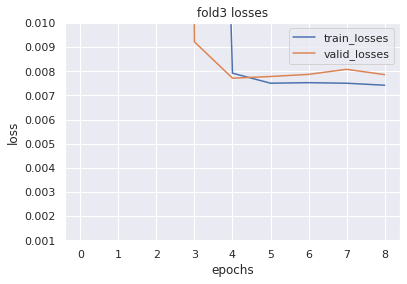

scored_loop
-----EPOCH1-----
train_loss: 0.64090, train_metric: 0.64081
valid_loss: 0.44146, valid_metric: 0.44114
-----EPOCH2-----
train_loss: 0.17769, train_metric: 0.17668
valid_loss: 0.04234, valid_metric: 0.04058
-----EPOCH3-----
train_loss: 0.02854, train_metric: 0.02632
valid_loss: 0.02363, valid_metric: 0.02111
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01918
valid_loss: 0.02173, valid_metric: 0.01881
-----EPOCH5-----
train_loss: 0.02111, train_metric: 0.01816
valid_loss: 0.02154, valid_metric: 0.01855
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01792
valid_loss: 0.02147, valid_metric: 0.01845
-----EPOCH7-----
train_loss: 0.02091, train_metric: 0.01785
valid_loss: 0.02143, valid_metric: 0.01832
-----EPOCH8-----
train_loss: 0.02089, train_metric: 0.01783
valid_loss: 0.02141, valid_metric: 0.01835
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02140, valid_metric: 0.01836
-----EPOCH10-----
train_loss: 0.02082, train_metric: 0.01777


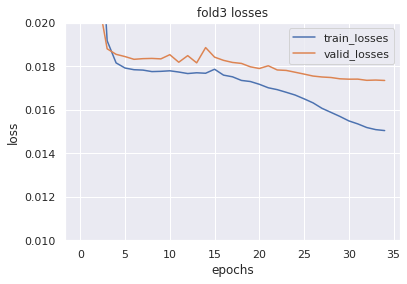

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72480, train_metric: 0.72480
valid_loss: 0.70631, valid_metric: 0.70632
-----EPOCH2-----
train_loss: 0.69100, train_metric: 0.69099
valid_loss: 0.65990, valid_metric: 0.65986
-----EPOCH3-----
train_loss: 0.52166, train_metric: 0.52145
valid_loss: 0.22249, valid_metric: 0.22179
-----EPOCH4-----
train_loss: 0.06297, train_metric: 0.06118
valid_loss: 0.01201, valid_metric: 0.00921
-----EPOCH5-----
train_loss: 0.01107, train_metric: 0.00793
valid_loss: 0.01099, valid_metric: 0.00778
-----EPOCH6-----
train_loss: 0.01075, train_metric: 0.00749
valid_loss: 0.01097, valid_metric: 0.00775
-----EPOCH7-----
train_loss: 0.01071, train_metric: 0.00751
valid_loss: 0.01104, valid_metric: 0.00792
-----EPOCH8-----
train_loss: 0.01067, train_metric: 0.00751
valid_loss: 0.01114, valid_metric: 0.00807
-----EPOCH9-----
train_loss: 0.01063, train_metric: 0.00746
valid_loss: 0.01106, valid_metric: 0.00795
-----EPOCH10-----
train_loss: 0.

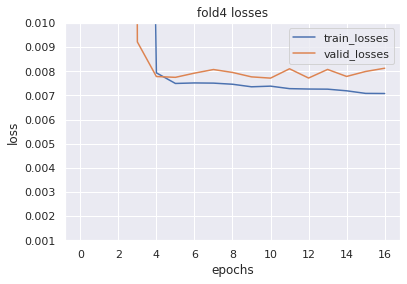

scored_loop
-----EPOCH1-----
train_loss: 0.62033, train_metric: 0.62022
valid_loss: 0.40230, valid_metric: 0.40192
-----EPOCH2-----
train_loss: 0.16130, train_metric: 0.16025
valid_loss: 0.04187, valid_metric: 0.04011
-----EPOCH3-----
train_loss: 0.02896, train_metric: 0.02677
valid_loss: 0.02314, valid_metric: 0.02062
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01920
valid_loss: 0.02122, valid_metric: 0.01834
-----EPOCH5-----
train_loss: 0.02094, train_metric: 0.01800
valid_loss: 0.02150, valid_metric: 0.01865
-----EPOCH6-----
train_loss: 0.02073, train_metric: 0.01771
valid_loss: 0.02106, valid_metric: 0.01798
-----EPOCH7-----
train_loss: 0.02064, train_metric: 0.01759
valid_loss: 0.02121, valid_metric: 0.01816
-----EPOCH8-----
train_loss: 0.02073, train_metric: 0.01768
valid_loss: 0.02127, valid_metric: 0.01826
-----EPOCH9-----
train_loss: 0.02061, train_metric: 0.01755
valid_loss: 0.02112, valid_metric: 0.01792
-----EPOCH10-----
train_loss: 0.02057, train_metric: 0.01751


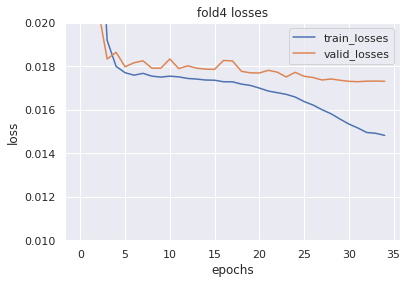

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72477, train_metric: 0.72477
valid_loss: 0.70734, valid_metric: 0.70734
-----EPOCH2-----
train_loss: 0.69104, train_metric: 0.69103
valid_loss: 0.66188, valid_metric: 0.66184
-----EPOCH3-----
train_loss: 0.52209, train_metric: 0.52188
valid_loss: 0.22734, valid_metric: 0.22665
-----EPOCH4-----
train_loss: 0.06331, train_metric: 0.06153
valid_loss: 0.01217, valid_metric: 0.00938
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00797
valid_loss: 0.01104, valid_metric: 0.00775
-----EPOCH6-----
train_loss: 0.01081, train_metric: 0.00755
valid_loss: 0.01102, valid_metric: 0.00784
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00756
valid_loss: 0.01102, valid_metric: 0.00788
-----EPOCH8-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01102, valid_metric: 0.00791
-----EPOCH9-----
train_loss: 0.01063, train_metric: 0.00746
valid_loss: 0.01099, valid_metric: 0.00783
-----EPOCH10-----
train_loss: 0.

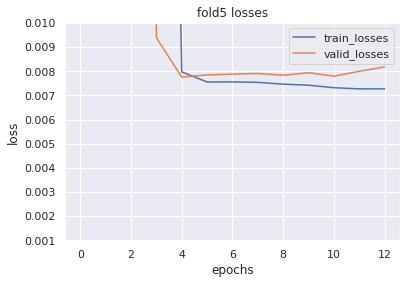

scored_loop
-----EPOCH1-----
train_loss: 0.63312, train_metric: 0.63303
valid_loss: 0.41554, valid_metric: 0.41519
-----EPOCH2-----
train_loss: 0.16931, train_metric: 0.16829
valid_loss: 0.04304, valid_metric: 0.04130
-----EPOCH3-----
train_loss: 0.02900, train_metric: 0.02681
valid_loss: 0.02336, valid_metric: 0.02081
-----EPOCH4-----
train_loss: 0.02200, train_metric: 0.01928
valid_loss: 0.02114, valid_metric: 0.01826
-----EPOCH5-----
train_loss: 0.02117, train_metric: 0.01823
valid_loss: 0.02086, valid_metric: 0.01788
-----EPOCH6-----
train_loss: 0.02079, train_metric: 0.01775
valid_loss: 0.02113, valid_metric: 0.01788
-----EPOCH7-----
train_loss: 0.02087, train_metric: 0.01781
valid_loss: 0.02109, valid_metric: 0.01815
-----EPOCH8-----
train_loss: 0.02082, train_metric: 0.01776
valid_loss: 0.02085, valid_metric: 0.01778
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01769
valid_loss: 0.02085, valid_metric: 0.01781
-----EPOCH10-----
train_loss: 0.02092, train_metric: 0.01787


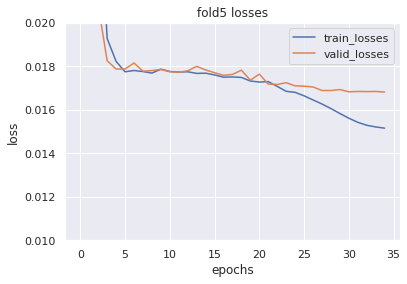

 
SEED : 2

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72629, train_metric: 0.72628
valid_loss: 0.70611, valid_metric: 0.70611
-----EPOCH2-----
train_loss: 0.69180, train_metric: 0.69179
valid_loss: 0.68163, valid_metric: 0.68161
-----EPOCH3-----
train_loss: 0.52051, train_metric: 0.52030
valid_loss: 0.23339, valid_metric: 0.23271
-----EPOCH4-----
train_loss: 0.06194, train_metric: 0.06016
valid_loss: 0.01207, valid_metric: 0.00928
-----EPOCH5-----
train_loss: 0.01098, train_metric: 0.00785
valid_loss: 0.01101, valid_metric: 0.00772
-----EPOCH6-----
train_loss: 0.01072, train_metric: 0.00747
valid_loss: 0.01102, valid_metric: 0.00779
-----EPOCH7-----
train_loss: 0.01073, train_metric: 0.00754
valid_loss: 0.01104, valid_metric: 0.00786
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00758
valid_loss: 0.01109, valid_metric: 0.00796
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00748
valid_loss: 0.01102, valid_metric: 0.00783
early_stopping


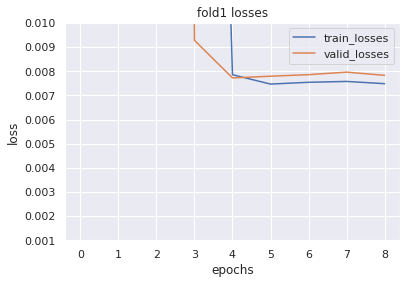

scored_loop
-----EPOCH1-----
train_loss: 0.64124, train_metric: 0.64116
valid_loss: 0.44338, valid_metric: 0.44307
-----EPOCH2-----
train_loss: 0.18066, train_metric: 0.17966
valid_loss: 0.04188, valid_metric: 0.04011
-----EPOCH3-----
train_loss: 0.02867, train_metric: 0.02646
valid_loss: 0.02305, valid_metric: 0.02051
-----EPOCH4-----
train_loss: 0.02199, train_metric: 0.01925
valid_loss: 0.02152, valid_metric: 0.01862
-----EPOCH5-----
train_loss: 0.02119, train_metric: 0.01824
valid_loss: 0.02170, valid_metric: 0.01862
-----EPOCH6-----
train_loss: 0.02108, train_metric: 0.01804
valid_loss: 0.02083, valid_metric: 0.01776
-----EPOCH7-----
train_loss: 0.02089, train_metric: 0.01783
valid_loss: 0.02094, valid_metric: 0.01792
-----EPOCH8-----
train_loss: 0.02096, train_metric: 0.01791
valid_loss: 0.02113, valid_metric: 0.01811
-----EPOCH9-----
train_loss: 0.02096, train_metric: 0.01791
valid_loss: 0.02093, valid_metric: 0.01781
-----EPOCH10-----
train_loss: 0.02092, train_metric: 0.01787


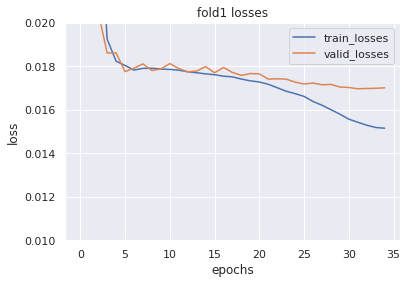

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72627, train_metric: 0.72627
valid_loss: 0.70581, valid_metric: 0.70581
-----EPOCH2-----
train_loss: 0.69160, train_metric: 0.69159
valid_loss: 0.67969, valid_metric: 0.67967
-----EPOCH3-----
train_loss: 0.52093, train_metric: 0.52072
valid_loss: 0.23440, valid_metric: 0.23372
-----EPOCH4-----
train_loss: 0.06214, train_metric: 0.06036
valid_loss: 0.01229, valid_metric: 0.00948
-----EPOCH5-----
train_loss: 0.01086, train_metric: 0.00773
valid_loss: 0.01147, valid_metric: 0.00820
-----EPOCH6-----
train_loss: 0.01056, train_metric: 0.00730
valid_loss: 0.01149, valid_metric: 0.00829
-----EPOCH7-----
train_loss: 0.01056, train_metric: 0.00736
valid_loss: 0.01151, valid_metric: 0.00831
-----EPOCH8-----
train_loss: 0.01055, train_metric: 0.00738
valid_loss: 0.01175, valid_metric: 0.00872
-----EPOCH9-----
train_loss: 0.01048, train_metric: 0.00731
valid_loss: 0.01156, valid_metric: 0.00841
early_stopping


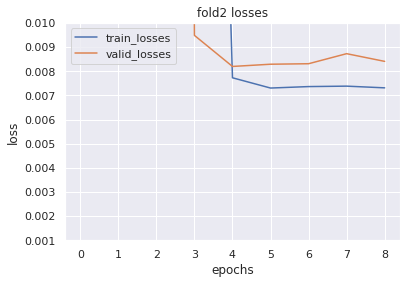

scored_loop
-----EPOCH1-----
train_loss: 0.64822, train_metric: 0.64814
valid_loss: 0.44673, valid_metric: 0.44643
-----EPOCH2-----
train_loss: 0.17999, train_metric: 0.17899
valid_loss: 0.04258, valid_metric: 0.04082
-----EPOCH3-----
train_loss: 0.02867, train_metric: 0.02645
valid_loss: 0.02352, valid_metric: 0.02100
-----EPOCH4-----
train_loss: 0.02197, train_metric: 0.01923
valid_loss: 0.02204, valid_metric: 0.01928
-----EPOCH5-----
train_loss: 0.02107, train_metric: 0.01811
valid_loss: 0.02159, valid_metric: 0.01857
-----EPOCH6-----
train_loss: 0.02084, train_metric: 0.01779
valid_loss: 0.02146, valid_metric: 0.01835
-----EPOCH7-----
train_loss: 0.02085, train_metric: 0.01778
valid_loss: 0.02205, valid_metric: 0.01915
-----EPOCH8-----
train_loss: 0.02087, train_metric: 0.01780
valid_loss: 0.02150, valid_metric: 0.01847
-----EPOCH9-----
train_loss: 0.02080, train_metric: 0.01774
valid_loss: 0.02187, valid_metric: 0.01880
-----EPOCH10-----
train_loss: 0.02083, train_metric: 0.01778


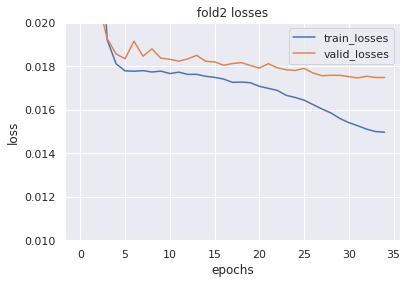

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72632, train_metric: 0.72631
valid_loss: 0.70739, valid_metric: 0.70739
-----EPOCH2-----
train_loss: 0.69178, train_metric: 0.69177
valid_loss: 0.67977, valid_metric: 0.67975
-----EPOCH3-----
train_loss: 0.52127, train_metric: 0.52106
valid_loss: 0.22773, valid_metric: 0.22704
-----EPOCH4-----
train_loss: 0.06251, train_metric: 0.06073
valid_loss: 0.01183, valid_metric: 0.00903
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00798
valid_loss: 0.01083, valid_metric: 0.00756
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00750
valid_loss: 0.01085, valid_metric: 0.00764
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01088, valid_metric: 0.00771
-----EPOCH8-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01090, valid_metric: 0.00775
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00748
valid_loss: 0.01096, valid_metric: 0.00785
early_stopping


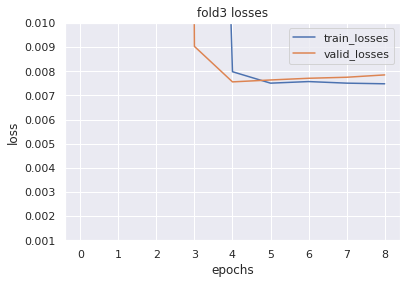

scored_loop
-----EPOCH1-----
train_loss: 0.64780, train_metric: 0.64772
valid_loss: 0.44824, valid_metric: 0.44794
-----EPOCH2-----
train_loss: 0.18062, train_metric: 0.17962
valid_loss: 0.04137, valid_metric: 0.03958
-----EPOCH3-----
train_loss: 0.02870, train_metric: 0.02648
valid_loss: 0.02344, valid_metric: 0.02089
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01917
valid_loss: 0.02177, valid_metric: 0.01884
-----EPOCH5-----
train_loss: 0.02117, train_metric: 0.01821
valid_loss: 0.02164, valid_metric: 0.01855
-----EPOCH6-----
train_loss: 0.02106, train_metric: 0.01802
valid_loss: 0.02160, valid_metric: 0.01847
-----EPOCH7-----
train_loss: 0.02096, train_metric: 0.01790
valid_loss: 0.02184, valid_metric: 0.01862
-----EPOCH8-----
train_loss: 0.02089, train_metric: 0.01784
valid_loss: 0.02157, valid_metric: 0.01843
-----EPOCH9-----
train_loss: 0.02093, train_metric: 0.01788
valid_loss: 0.02157, valid_metric: 0.01846
-----EPOCH10-----
train_loss: 0.02091, train_metric: 0.01786


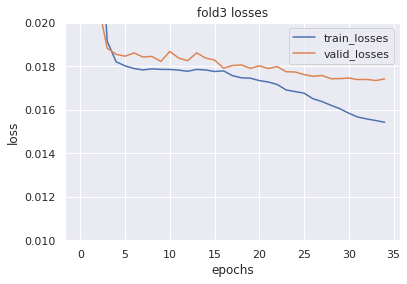

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72619, train_metric: 0.72619
valid_loss: 0.70602, valid_metric: 0.70602
-----EPOCH2-----
train_loss: 0.69161, train_metric: 0.69160
valid_loss: 0.67704, valid_metric: 0.67702
-----EPOCH3-----
train_loss: 0.52035, train_metric: 0.52014
valid_loss: 0.23489, valid_metric: 0.23422
-----EPOCH4-----
train_loss: 0.06204, train_metric: 0.06026
valid_loss: 0.01159, valid_metric: 0.00879
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00797
valid_loss: 0.01055, valid_metric: 0.00730
-----EPOCH6-----
train_loss: 0.01080, train_metric: 0.00755
valid_loss: 0.01052, valid_metric: 0.00729
-----EPOCH7-----
train_loss: 0.01087, train_metric: 0.00767
valid_loss: 0.01058, valid_metric: 0.00741
-----EPOCH8-----
train_loss: 0.01078, train_metric: 0.00763
valid_loss: 0.01054, valid_metric: 0.00738
-----EPOCH9-----
train_loss: 0.01073, train_metric: 0.00758
valid_loss: 0.01063, valid_metric: 0.00751
-----EPOCH10-----
train_loss: 0.

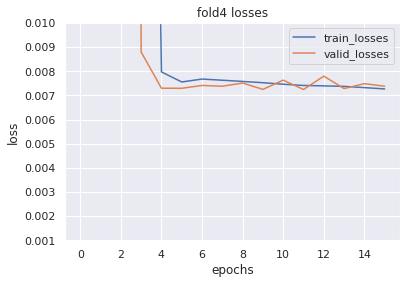

scored_loop
-----EPOCH1-----
train_loss: 0.62440, train_metric: 0.62430
valid_loss: 0.40737, valid_metric: 0.40700
-----EPOCH2-----
train_loss: 0.16455, train_metric: 0.16352
valid_loss: 0.04200, valid_metric: 0.04024
-----EPOCH3-----
train_loss: 0.02899, train_metric: 0.02680
valid_loss: 0.02317, valid_metric: 0.02067
-----EPOCH4-----
train_loss: 0.02189, train_metric: 0.01918
valid_loss: 0.02106, valid_metric: 0.01808
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01809
valid_loss: 0.02114, valid_metric: 0.01814
-----EPOCH6-----
train_loss: 0.02080, train_metric: 0.01776
valid_loss: 0.02117, valid_metric: 0.01828
-----EPOCH7-----
train_loss: 0.02067, train_metric: 0.01762
valid_loss: 0.02072, valid_metric: 0.01768
-----EPOCH8-----
train_loss: 0.02069, train_metric: 0.01763
valid_loss: 0.02137, valid_metric: 0.01825
-----EPOCH9-----
train_loss: 0.02065, train_metric: 0.01759
valid_loss: 0.02080, valid_metric: 0.01769
-----EPOCH10-----
train_loss: 0.02072, train_metric: 0.01767


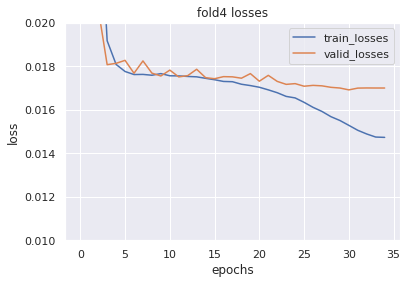

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72626, train_metric: 0.72626
valid_loss: 0.70656, valid_metric: 0.70656
-----EPOCH2-----
train_loss: 0.69160, train_metric: 0.69159
valid_loss: 0.67632, valid_metric: 0.67630
-----EPOCH3-----
train_loss: 0.51983, train_metric: 0.51962
valid_loss: 0.22842, valid_metric: 0.22773
-----EPOCH4-----
train_loss: 0.06164, train_metric: 0.05985
valid_loss: 0.01184, valid_metric: 0.00904
-----EPOCH5-----
train_loss: 0.01101, train_metric: 0.00788
valid_loss: 0.01083, valid_metric: 0.00757
-----EPOCH6-----
train_loss: 0.01077, train_metric: 0.00751
valid_loss: 0.01083, valid_metric: 0.00763
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00756
valid_loss: 0.01095, valid_metric: 0.00784
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01084, valid_metric: 0.00768
-----EPOCH9-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01083, valid_metric: 0.00764
early_stopping


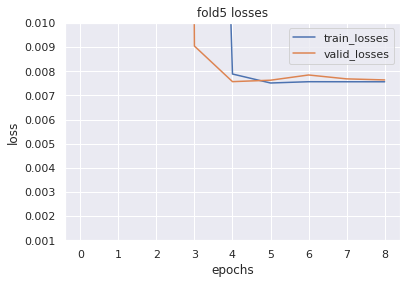

scored_loop
-----EPOCH1-----
train_loss: 0.65260, train_metric: 0.65252
valid_loss: 0.44830, valid_metric: 0.44801
-----EPOCH2-----
train_loss: 0.18159, train_metric: 0.18060
valid_loss: 0.04244, valid_metric: 0.04068
-----EPOCH3-----
train_loss: 0.02875, train_metric: 0.02653
valid_loss: 0.02302, valid_metric: 0.02048
-----EPOCH4-----
train_loss: 0.02196, train_metric: 0.01921
valid_loss: 0.02151, valid_metric: 0.01863
-----EPOCH5-----
train_loss: 0.02114, train_metric: 0.01818
valid_loss: 0.02137, valid_metric: 0.01842
-----EPOCH6-----
train_loss: 0.02103, train_metric: 0.01798
valid_loss: 0.02112, valid_metric: 0.01800
-----EPOCH7-----
train_loss: 0.02085, train_metric: 0.01778
valid_loss: 0.02123, valid_metric: 0.01814
-----EPOCH8-----
train_loss: 0.02087, train_metric: 0.01781
valid_loss: 0.02113, valid_metric: 0.01799
-----EPOCH9-----
train_loss: 0.02080, train_metric: 0.01774
valid_loss: 0.02092, valid_metric: 0.01777
-----EPOCH10-----
train_loss: 0.02083, train_metric: 0.01778


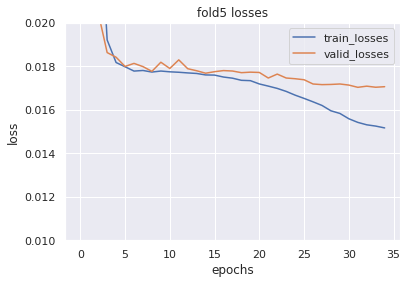

 
SEED : 3

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72631, train_metric: 0.72630
valid_loss: 0.70146, valid_metric: 0.70146
-----EPOCH2-----
train_loss: 0.69243, train_metric: 0.69242
valid_loss: 0.67151, valid_metric: 0.67148
-----EPOCH3-----
train_loss: 0.52092, train_metric: 0.52071
valid_loss: 0.22667, valid_metric: 0.22598
-----EPOCH4-----
train_loss: 0.06180, train_metric: 0.06001
valid_loss: 0.01163, valid_metric: 0.00884
-----EPOCH5-----
train_loss: 0.01110, train_metric: 0.00796
valid_loss: 0.01058, valid_metric: 0.00732
-----EPOCH6-----
train_loss: 0.01081, train_metric: 0.00755
valid_loss: 0.01062, valid_metric: 0.00740
-----EPOCH7-----
train_loss: 0.01076, train_metric: 0.00757
valid_loss: 0.01058, valid_metric: 0.00737
-----EPOCH8-----
train_loss: 0.01076, train_metric: 0.00760
valid_loss: 0.01075, valid_metric: 0.00763
-----EPOCH9-----
train_loss: 0.01070, train_metric: 0.00754
valid_loss: 0.01067, valid_metric: 0.00753
early_stopping


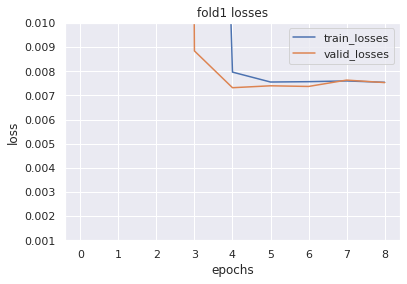

scored_loop
-----EPOCH1-----
train_loss: 0.64745, train_metric: 0.64737
valid_loss: 0.44957, valid_metric: 0.44928
-----EPOCH2-----
train_loss: 0.18197, train_metric: 0.18097
valid_loss: 0.04290, valid_metric: 0.04115
-----EPOCH3-----
train_loss: 0.02904, train_metric: 0.02683
valid_loss: 0.02341, valid_metric: 0.02089
-----EPOCH4-----
train_loss: 0.02210, train_metric: 0.01936
valid_loss: 0.02131, valid_metric: 0.01839
-----EPOCH5-----
train_loss: 0.02118, train_metric: 0.01822
valid_loss: 0.02093, valid_metric: 0.01796
-----EPOCH6-----
train_loss: 0.02101, train_metric: 0.01797
valid_loss: 0.02109, valid_metric: 0.01796
-----EPOCH7-----
train_loss: 0.02107, train_metric: 0.01801
valid_loss: 0.02102, valid_metric: 0.01799
-----EPOCH8-----
train_loss: 0.02099, train_metric: 0.01793
valid_loss: 0.02091, valid_metric: 0.01794
-----EPOCH9-----
train_loss: 0.02096, train_metric: 0.01791
valid_loss: 0.02104, valid_metric: 0.01781
-----EPOCH10-----
train_loss: 0.02094, train_metric: 0.01790


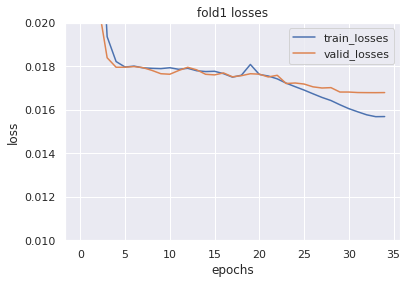

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72633, train_metric: 0.72633
valid_loss: 0.69900, valid_metric: 0.69900
-----EPOCH2-----
train_loss: 0.69234, train_metric: 0.69233
valid_loss: 0.67677, valid_metric: 0.67675
-----EPOCH3-----
train_loss: 0.52050, train_metric: 0.52029
valid_loss: 0.22763, valid_metric: 0.22694
-----EPOCH4-----
train_loss: 0.06157, train_metric: 0.05978
valid_loss: 0.01275, valid_metric: 0.00999
-----EPOCH5-----
train_loss: 0.01086, train_metric: 0.00772
valid_loss: 0.01166, valid_metric: 0.00840
-----EPOCH6-----
train_loss: 0.01062, train_metric: 0.00736
valid_loss: 0.01164, valid_metric: 0.00846
-----EPOCH7-----
train_loss: 0.01054, train_metric: 0.00734
valid_loss: 0.01169, valid_metric: 0.00854
-----EPOCH8-----
train_loss: 0.01052, train_metric: 0.00735
valid_loss: 0.01167, valid_metric: 0.00850
-----EPOCH9-----
train_loss: 0.01043, train_metric: 0.00726
valid_loss: 0.01167, valid_metric: 0.00852
-----EPOCH10-----
train_loss: 0.

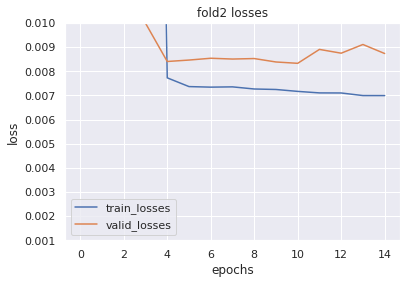

scored_loop
-----EPOCH1-----
train_loss: 0.63035, train_metric: 0.63025
valid_loss: 0.41858, valid_metric: 0.41824
-----EPOCH2-----
train_loss: 0.16779, train_metric: 0.16676
valid_loss: 0.04246, valid_metric: 0.04070
-----EPOCH3-----
train_loss: 0.02875, train_metric: 0.02656
valid_loss: 0.02359, valid_metric: 0.02114
-----EPOCH4-----
train_loss: 0.02170, train_metric: 0.01898
valid_loss: 0.02116, valid_metric: 0.01827
-----EPOCH5-----
train_loss: 0.02079, train_metric: 0.01783
valid_loss: 0.02110, valid_metric: 0.01807
-----EPOCH6-----
train_loss: 0.02055, train_metric: 0.01752
valid_loss: 0.02094, valid_metric: 0.01783
-----EPOCH7-----
train_loss: 0.02060, train_metric: 0.01754
valid_loss: 0.02149, valid_metric: 0.01855
-----EPOCH8-----
train_loss: 0.02069, train_metric: 0.01763
valid_loss: 0.02147, valid_metric: 0.01834
-----EPOCH9-----
train_loss: 0.02065, train_metric: 0.01760
valid_loss: 0.02093, valid_metric: 0.01778
-----EPOCH10-----
train_loss: 0.02050, train_metric: 0.01744


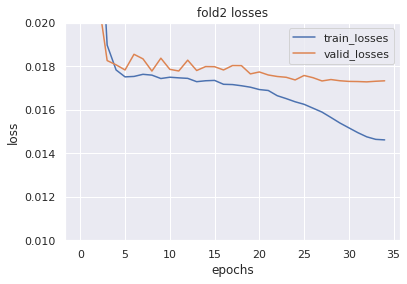

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72638, train_metric: 0.72638
valid_loss: 0.70100, valid_metric: 0.70100
-----EPOCH2-----
train_loss: 0.69229, train_metric: 0.69228
valid_loss: 0.66900, valid_metric: 0.66897
-----EPOCH3-----
train_loss: 0.52045, train_metric: 0.52024
valid_loss: 0.23317, valid_metric: 0.23249
-----EPOCH4-----
train_loss: 0.06146, train_metric: 0.05966
valid_loss: 0.01199, valid_metric: 0.00919
-----EPOCH5-----
train_loss: 0.01097, train_metric: 0.00784
valid_loss: 0.01099, valid_metric: 0.00771
-----EPOCH6-----
train_loss: 0.01077, train_metric: 0.00751
valid_loss: 0.01094, valid_metric: 0.00768
-----EPOCH7-----
train_loss: 0.01070, train_metric: 0.00751
valid_loss: 0.01102, valid_metric: 0.00787
-----EPOCH8-----
train_loss: 0.01064, train_metric: 0.00748
valid_loss: 0.01110, valid_metric: 0.00797
-----EPOCH9-----
train_loss: 0.01058, train_metric: 0.00742
valid_loss: 0.01112, valid_metric: 0.00805
-----EPOCH10-----
train_loss: 0.

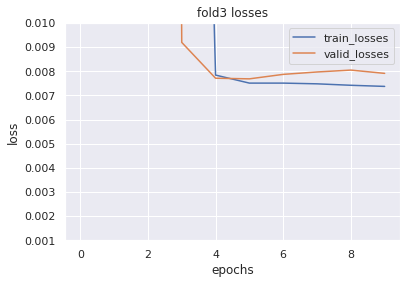

scored_loop
-----EPOCH1-----
train_loss: 0.63299, train_metric: 0.63290
valid_loss: 0.43420, valid_metric: 0.43388
-----EPOCH2-----
train_loss: 0.17465, train_metric: 0.17364
valid_loss: 0.04187, valid_metric: 0.04010
-----EPOCH3-----
train_loss: 0.02843, train_metric: 0.02621
valid_loss: 0.02290, valid_metric: 0.02029
-----EPOCH4-----
train_loss: 0.02184, train_metric: 0.01910
valid_loss: 0.02159, valid_metric: 0.01870
-----EPOCH5-----
train_loss: 0.02107, train_metric: 0.01811
valid_loss: 0.02134, valid_metric: 0.01835
-----EPOCH6-----
train_loss: 0.02087, train_metric: 0.01783
valid_loss: 0.02144, valid_metric: 0.01850
-----EPOCH7-----
train_loss: 0.02080, train_metric: 0.01774
valid_loss: 0.02119, valid_metric: 0.01814
-----EPOCH8-----
train_loss: 0.02090, train_metric: 0.01784
valid_loss: 0.02145, valid_metric: 0.01829
-----EPOCH9-----
train_loss: 0.02078, train_metric: 0.01773
valid_loss: 0.02104, valid_metric: 0.01795
-----EPOCH10-----
train_loss: 0.02075, train_metric: 0.01770


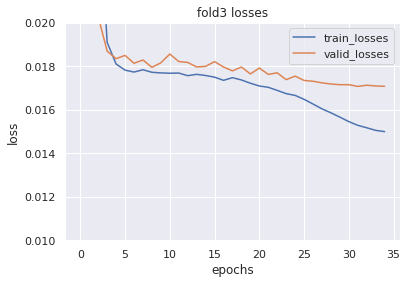

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72629, train_metric: 0.72629
valid_loss: 0.69965, valid_metric: 0.69964
-----EPOCH2-----
train_loss: 0.69242, train_metric: 0.69241
valid_loss: 0.67251, valid_metric: 0.67248
-----EPOCH3-----
train_loss: 0.52099, train_metric: 0.52078
valid_loss: 0.23099, valid_metric: 0.23030
-----EPOCH4-----
train_loss: 0.06190, train_metric: 0.06011
valid_loss: 0.01166, valid_metric: 0.00885
-----EPOCH5-----
train_loss: 0.01106, train_metric: 0.00793
valid_loss: 0.01065, valid_metric: 0.00737
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01071, valid_metric: 0.00752
-----EPOCH7-----
train_loss: 0.01080, train_metric: 0.00761
valid_loss: 0.01071, valid_metric: 0.00753
-----EPOCH8-----
train_loss: 0.01073, train_metric: 0.00756
valid_loss: 0.01080, valid_metric: 0.00769
-----EPOCH9-----
train_loss: 0.01064, train_metric: 0.00748
valid_loss: 0.01095, valid_metric: 0.00791
early_stopping


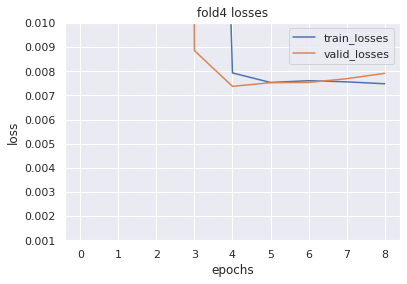

scored_loop
-----EPOCH1-----
train_loss: 0.64169, train_metric: 0.64161
valid_loss: 0.44744, valid_metric: 0.44713
-----EPOCH2-----
train_loss: 0.17964, train_metric: 0.17863
valid_loss: 0.04195, valid_metric: 0.04018
-----EPOCH3-----
train_loss: 0.02846, train_metric: 0.02623
valid_loss: 0.02329, valid_metric: 0.02075
-----EPOCH4-----
train_loss: 0.02191, train_metric: 0.01916
valid_loss: 0.02179, valid_metric: 0.01889
-----EPOCH5-----
train_loss: 0.02106, train_metric: 0.01809
valid_loss: 0.02162, valid_metric: 0.01867
-----EPOCH6-----
train_loss: 0.02099, train_metric: 0.01795
valid_loss: 0.02144, valid_metric: 0.01837
-----EPOCH7-----
train_loss: 0.02095, train_metric: 0.01789
valid_loss: 0.02132, valid_metric: 0.01820
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01782
valid_loss: 0.02136, valid_metric: 0.01837
-----EPOCH9-----
train_loss: 0.02082, train_metric: 0.01777
valid_loss: 0.02140, valid_metric: 0.01827
-----EPOCH10-----
train_loss: 0.02080, train_metric: 0.01775


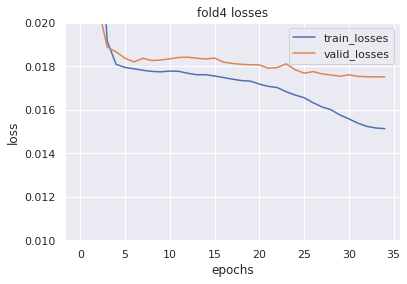

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72642, train_metric: 0.72642
valid_loss: 0.70023, valid_metric: 0.70022
-----EPOCH2-----
train_loss: 0.69250, train_metric: 0.69249
valid_loss: 0.67383, valid_metric: 0.67380
-----EPOCH3-----
train_loss: 0.52122, train_metric: 0.52101
valid_loss: 0.22527, valid_metric: 0.22457
-----EPOCH4-----
train_loss: 0.06188, train_metric: 0.06009
valid_loss: 0.01195, valid_metric: 0.00916
-----EPOCH5-----
train_loss: 0.01100, train_metric: 0.00786
valid_loss: 0.01094, valid_metric: 0.00767
-----EPOCH6-----
train_loss: 0.01078, train_metric: 0.00752
valid_loss: 0.01095, valid_metric: 0.00776
-----EPOCH7-----
train_loss: 0.01064, train_metric: 0.00744
valid_loss: 0.01095, valid_metric: 0.00779
-----EPOCH8-----
train_loss: 0.01059, train_metric: 0.00742
valid_loss: 0.01097, valid_metric: 0.00782
-----EPOCH9-----
train_loss: 0.01051, train_metric: 0.00734
valid_loss: 0.01100, valid_metric: 0.00784
early_stopping


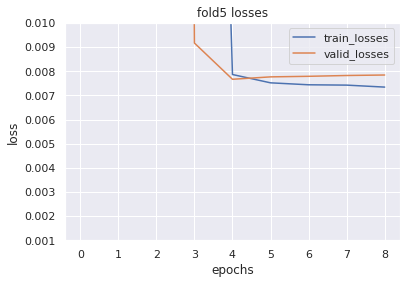

scored_loop
-----EPOCH1-----
train_loss: 0.65158, train_metric: 0.65150
valid_loss: 0.45394, valid_metric: 0.45364
-----EPOCH2-----
train_loss: 0.18305, train_metric: 0.18205
valid_loss: 0.04177, valid_metric: 0.04000
-----EPOCH3-----
train_loss: 0.02861, train_metric: 0.02638
valid_loss: 0.02323, valid_metric: 0.02070
-----EPOCH4-----
train_loss: 0.02194, train_metric: 0.01920
valid_loss: 0.02138, valid_metric: 0.01844
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01811
valid_loss: 0.02118, valid_metric: 0.01814
-----EPOCH6-----
train_loss: 0.02091, train_metric: 0.01787
valid_loss: 0.02101, valid_metric: 0.01795
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01784
valid_loss: 0.02116, valid_metric: 0.01820
-----EPOCH8-----
train_loss: 0.02088, train_metric: 0.01782
valid_loss: 0.02113, valid_metric: 0.01795
-----EPOCH9-----
train_loss: 0.02085, train_metric: 0.01780
valid_loss: 0.02107, valid_metric: 0.01806
-----EPOCH10-----
train_loss: 0.02082, train_metric: 0.01777


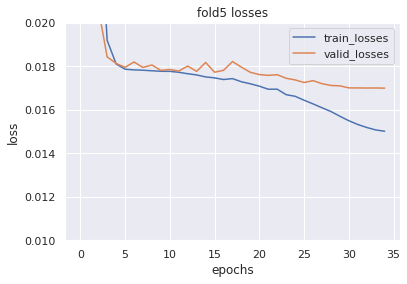

 
SEED : 4

==========FOLD1==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72716, train_metric: 0.72716
valid_loss: 0.70474, valid_metric: 0.70474
-----EPOCH2-----
train_loss: 0.69270, train_metric: 0.69270
valid_loss: 0.68124, valid_metric: 0.68122
-----EPOCH3-----
train_loss: 0.52177, train_metric: 0.52156
valid_loss: 0.23153, valid_metric: 0.23085
-----EPOCH4-----
train_loss: 0.06228, train_metric: 0.06049
valid_loss: 0.01228, valid_metric: 0.00948
-----EPOCH5-----
train_loss: 0.01091, train_metric: 0.00778
valid_loss: 0.01131, valid_metric: 0.00807
-----EPOCH6-----
train_loss: 0.01065, train_metric: 0.00739
valid_loss: 0.01128, valid_metric: 0.00807
-----EPOCH7-----
train_loss: 0.01062, train_metric: 0.00742
valid_loss: 0.01130, valid_metric: 0.00813
-----EPOCH8-----
train_loss: 0.01059, train_metric: 0.00742
valid_loss: 0.01132, valid_metric: 0.00816
-----EPOCH9-----
train_loss: 0.01051, train_metric: 0.00734
valid_loss: 0.01144, valid_metric: 0.00836
-----EPOCH10-----
tr

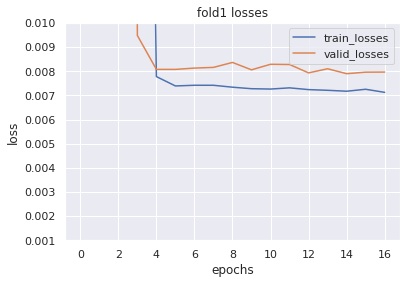

scored_loop
-----EPOCH1-----
train_loss: 0.61033, train_metric: 0.61021
valid_loss: 0.39588, valid_metric: 0.39550
-----EPOCH2-----
train_loss: 0.15870, train_metric: 0.15764
valid_loss: 0.04111, valid_metric: 0.03933
-----EPOCH3-----
train_loss: 0.02869, train_metric: 0.02649
valid_loss: 0.02385, valid_metric: 0.02130
-----EPOCH4-----
train_loss: 0.02192, train_metric: 0.01921
valid_loss: 0.02157, valid_metric: 0.01872
-----EPOCH5-----
train_loss: 0.02108, train_metric: 0.01814
valid_loss: 0.02100, valid_metric: 0.01806
-----EPOCH6-----
train_loss: 0.02079, train_metric: 0.01777
valid_loss: 0.02091, valid_metric: 0.01788
-----EPOCH7-----
train_loss: 0.02066, train_metric: 0.01760
valid_loss: 0.02088, valid_metric: 0.01788
-----EPOCH8-----
train_loss: 0.02065, train_metric: 0.01760
valid_loss: 0.02098, valid_metric: 0.01787
-----EPOCH9-----
train_loss: 0.02063, train_metric: 0.01758
valid_loss: 0.02112, valid_metric: 0.01804
-----EPOCH10-----
train_loss: 0.02065, train_metric: 0.01759


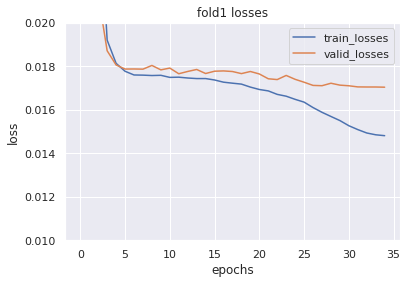

==========FOLD2==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72721, train_metric: 0.72721
valid_loss: 0.70400, valid_metric: 0.70400
-----EPOCH2-----
train_loss: 0.69281, train_metric: 0.69280
valid_loss: 0.68393, valid_metric: 0.68392
-----EPOCH3-----
train_loss: 0.52199, train_metric: 0.52178
valid_loss: 0.23605, valid_metric: 0.23538
-----EPOCH4-----
train_loss: 0.06239, train_metric: 0.06061
valid_loss: 0.01183, valid_metric: 0.00905
-----EPOCH5-----
train_loss: 0.01106, train_metric: 0.00793
valid_loss: 0.01069, valid_metric: 0.00741
-----EPOCH6-----
train_loss: 0.01076, train_metric: 0.00751
valid_loss: 0.01073, valid_metric: 0.00749
-----EPOCH7-----
train_loss: 0.01072, train_metric: 0.00752
valid_loss: 0.01072, valid_metric: 0.00751
-----EPOCH8-----
train_loss: 0.01070, train_metric: 0.00753
valid_loss: 0.01083, valid_metric: 0.00766
-----EPOCH9-----
train_loss: 0.01067, train_metric: 0.00750
valid_loss: 0.01078, valid_metric: 0.00762
early_stopping


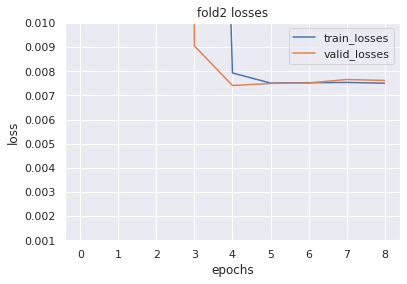

scored_loop
-----EPOCH1-----
train_loss: 0.64287, train_metric: 0.64279
valid_loss: 0.44236, valid_metric: 0.44205
-----EPOCH2-----
train_loss: 0.18057, train_metric: 0.17957
valid_loss: 0.04179, valid_metric: 0.04002
-----EPOCH3-----
train_loss: 0.02861, train_metric: 0.02639
valid_loss: 0.02315, valid_metric: 0.02061
-----EPOCH4-----
train_loss: 0.02197, train_metric: 0.01923
valid_loss: 0.02131, valid_metric: 0.01839
-----EPOCH5-----
train_loss: 0.02128, train_metric: 0.01832
valid_loss: 0.02117, valid_metric: 0.01821
-----EPOCH6-----
train_loss: 0.02106, train_metric: 0.01803
valid_loss: 0.02155, valid_metric: 0.01846
-----EPOCH7-----
train_loss: 0.02107, train_metric: 0.01801
valid_loss: 0.02150, valid_metric: 0.01826
-----EPOCH8-----
train_loss: 0.02105, train_metric: 0.01799
valid_loss: 0.02100, valid_metric: 0.01794
-----EPOCH9-----
train_loss: 0.02089, train_metric: 0.01785
valid_loss: 0.02109, valid_metric: 0.01797
-----EPOCH10-----
train_loss: 0.02097, train_metric: 0.01791


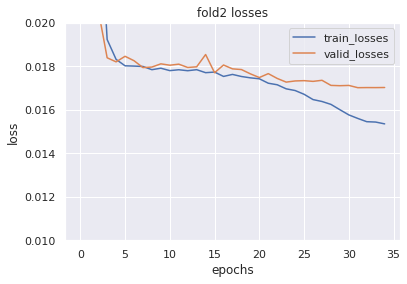

==========FOLD3==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72722, train_metric: 0.72721
valid_loss: 0.70479, valid_metric: 0.70479
-----EPOCH2-----
train_loss: 0.69285, train_metric: 0.69284
valid_loss: 0.67968, valid_metric: 0.67965
-----EPOCH3-----
train_loss: 0.52155, train_metric: 0.52134
valid_loss: 0.23255, valid_metric: 0.23187
-----EPOCH4-----
train_loss: 0.06230, train_metric: 0.06052
valid_loss: 0.01181, valid_metric: 0.00903
-----EPOCH5-----
train_loss: 0.01100, train_metric: 0.00787
valid_loss: 0.01073, valid_metric: 0.00747
-----EPOCH6-----
train_loss: 0.01079, train_metric: 0.00753
valid_loss: 0.01077, valid_metric: 0.00757
-----EPOCH7-----
train_loss: 0.01075, train_metric: 0.00755
valid_loss: 0.01080, valid_metric: 0.00762
-----EPOCH8-----
train_loss: 0.01066, train_metric: 0.00749
valid_loss: 0.01082, valid_metric: 0.00765
-----EPOCH9-----
train_loss: 0.01063, train_metric: 0.00746
valid_loss: 0.01077, valid_metric: 0.00756
early_stopping


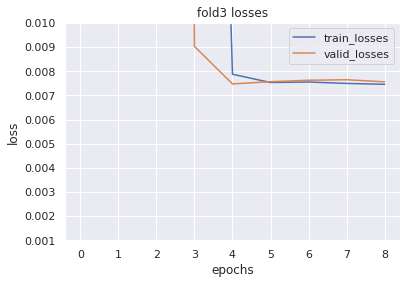

scored_loop
-----EPOCH1-----
train_loss: 0.64515, train_metric: 0.64507
valid_loss: 0.44509, valid_metric: 0.44479
-----EPOCH2-----
train_loss: 0.18056, train_metric: 0.17957
valid_loss: 0.04249, valid_metric: 0.04073
-----EPOCH3-----
train_loss: 0.02857, train_metric: 0.02635
valid_loss: 0.02312, valid_metric: 0.02056
-----EPOCH4-----
train_loss: 0.02194, train_metric: 0.01919
valid_loss: 0.02156, valid_metric: 0.01869
-----EPOCH5-----
train_loss: 0.02110, train_metric: 0.01814
valid_loss: 0.02127, valid_metric: 0.01825
-----EPOCH6-----
train_loss: 0.02097, train_metric: 0.01792
valid_loss: 0.02126, valid_metric: 0.01818
-----EPOCH7-----
train_loss: 0.02099, train_metric: 0.01792
valid_loss: 0.02135, valid_metric: 0.01832
-----EPOCH8-----
train_loss: 0.02090, train_metric: 0.01784
valid_loss: 0.02148, valid_metric: 0.01845
-----EPOCH9-----
train_loss: 0.02083, train_metric: 0.01777
valid_loss: 0.02145, valid_metric: 0.01836
-----EPOCH10-----
train_loss: 0.02090, train_metric: 0.01785


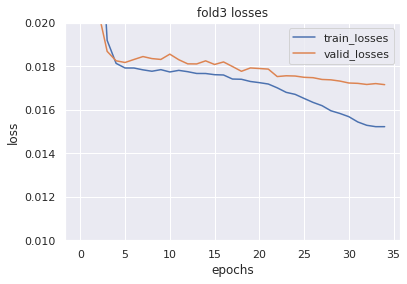

==========FOLD4==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72715, train_metric: 0.72715
valid_loss: 0.70380, valid_metric: 0.70380
-----EPOCH2-----
train_loss: 0.69289, train_metric: 0.69288
valid_loss: 0.68052, valid_metric: 0.68050
-----EPOCH3-----
train_loss: 0.52032, train_metric: 0.52011
valid_loss: 0.22563, valid_metric: 0.22493
-----EPOCH4-----
train_loss: 0.06124, train_metric: 0.05944
valid_loss: 0.01221, valid_metric: 0.00940
-----EPOCH5-----
train_loss: 0.01091, train_metric: 0.00777
valid_loss: 0.01132, valid_metric: 0.00809
-----EPOCH6-----
train_loss: 0.01065, train_metric: 0.00739
valid_loss: 0.01131, valid_metric: 0.00801
-----EPOCH7-----
train_loss: 0.01064, train_metric: 0.00743
valid_loss: 0.01146, valid_metric: 0.00835
-----EPOCH8-----
train_loss: 0.01056, train_metric: 0.00739
valid_loss: 0.01149, valid_metric: 0.00842
-----EPOCH9-----
train_loss: 0.01056, train_metric: 0.00740
valid_loss: 0.01145, valid_metric: 0.00836
-----EPOCH10-----
train_loss: 0.

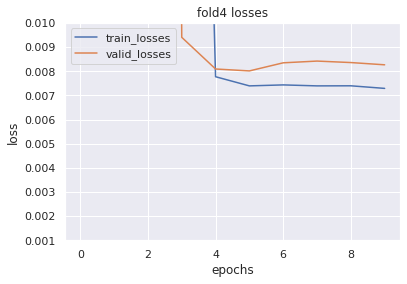

scored_loop
-----EPOCH1-----
train_loss: 0.63172, train_metric: 0.63162
valid_loss: 0.43763, valid_metric: 0.43731
-----EPOCH2-----
train_loss: 0.17567, train_metric: 0.17467
valid_loss: 0.04398, valid_metric: 0.04225
-----EPOCH3-----
train_loss: 0.02879, train_metric: 0.02658
valid_loss: 0.02315, valid_metric: 0.02060
-----EPOCH4-----
train_loss: 0.02198, train_metric: 0.01925
valid_loss: 0.02148, valid_metric: 0.01861
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01807
valid_loss: 0.02115, valid_metric: 0.01813
-----EPOCH6-----
train_loss: 0.02096, train_metric: 0.01791
valid_loss: 0.02128, valid_metric: 0.01809
-----EPOCH7-----
train_loss: 0.02084, train_metric: 0.01777
valid_loss: 0.02106, valid_metric: 0.01803
-----EPOCH8-----
train_loss: 0.02087, train_metric: 0.01781
valid_loss: 0.02095, valid_metric: 0.01794
-----EPOCH9-----
train_loss: 0.02081, train_metric: 0.01776
valid_loss: 0.02110, valid_metric: 0.01813
-----EPOCH10-----
train_loss: 0.02082, train_metric: 0.01777


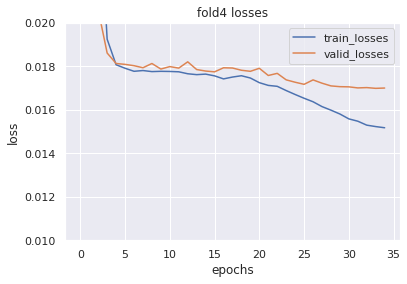

==========FOLD5==========
nonscored-loop
-----EPOCH1-----
train_loss: 0.72722, train_metric: 0.72722
valid_loss: 0.70414, valid_metric: 0.70414
-----EPOCH2-----
train_loss: 0.69281, train_metric: 0.69280
valid_loss: 0.68332, valid_metric: 0.68331
-----EPOCH3-----
train_loss: 0.52016, train_metric: 0.51994
valid_loss: 0.22784, valid_metric: 0.22714
-----EPOCH4-----
train_loss: 0.06125, train_metric: 0.05945
valid_loss: 0.01165, valid_metric: 0.00884
-----EPOCH5-----
train_loss: 0.01104, train_metric: 0.00791
valid_loss: 0.01065, valid_metric: 0.00737
-----EPOCH6-----
train_loss: 0.01080, train_metric: 0.00754
valid_loss: 0.01068, valid_metric: 0.00743
-----EPOCH7-----
train_loss: 0.01077, train_metric: 0.00758
valid_loss: 0.01072, valid_metric: 0.00756
-----EPOCH8-----
train_loss: 0.01072, train_metric: 0.00756
valid_loss: 0.01078, valid_metric: 0.00769
-----EPOCH9-----
train_loss: 0.01068, train_metric: 0.00752
valid_loss: 0.01079, valid_metric: 0.00767
early_stopping


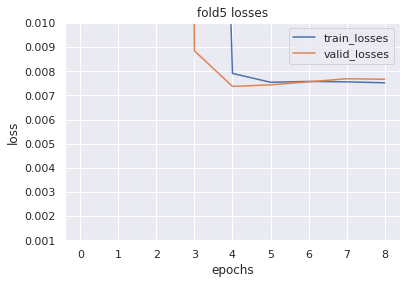

scored_loop
-----EPOCH1-----
train_loss: 0.65888, train_metric: 0.65881
valid_loss: 0.45462, valid_metric: 0.45433
-----EPOCH2-----
train_loss: 0.18425, train_metric: 0.18326
valid_loss: 0.04330, valid_metric: 0.04155
-----EPOCH3-----
train_loss: 0.02862, train_metric: 0.02640
valid_loss: 0.02375, valid_metric: 0.02123
-----EPOCH4-----
train_loss: 0.02185, train_metric: 0.01911
valid_loss: 0.02179, valid_metric: 0.01895
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01807
valid_loss: 0.02135, valid_metric: 0.01827
-----EPOCH6-----
train_loss: 0.02090, train_metric: 0.01786
valid_loss: 0.02154, valid_metric: 0.01852
-----EPOCH7-----
train_loss: 0.02078, train_metric: 0.01771
valid_loss: 0.02135, valid_metric: 0.01819
-----EPOCH8-----
train_loss: 0.02079, train_metric: 0.01772
valid_loss: 0.02126, valid_metric: 0.01812
-----EPOCH9-----
train_loss: 0.02075, train_metric: 0.01769
valid_loss: 0.02114, valid_metric: 0.01811
-----EPOCH10-----
train_loss: 0.02077, train_metric: 0.01772


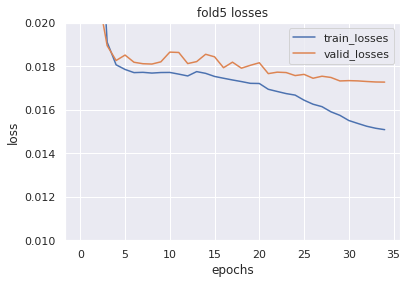

In [35]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))
CVs = list()

print(f'used device: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_, CVs_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    CVs += CVs_
    
train[target_cols] = oof
test[target_cols] = predictions

In [36]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f} +/- {np.std(CVs):.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.015615 +/- 0.000327
AUC: 0.664296


In [37]:
file_path = 'oof_ResNet.npy'
np.save(file_path, oof)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [38]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
